In [1]:
!pip install feedparser
!pip install yfinance
!pip install nltk
!pip install torch
import torch
import feedparser
import yfinance as yf
import nltk
from datetime import datetime
from collections import namedtuple
import requests
!pip install transformers -q
from transformers import pipeline
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anuta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Use the feedparser library to parse the RSS feed into a list of titles. 
feed_url = 'https://feeds.a.dj.com/rss/RSSMarketsMain.xml'
feed = feedparser.parse(feed_url)

# Create a struct for the pair (Ticker, Date Published) to help with lookup
Ticker_Data = namedtuple("Ticker_Time", ["ticker", "time", "sentiment"])

In [3]:
# From a company name, get the corresponding ticker. Source: https://stackoverflow.com/a/38968465
def get_ticker(company_name):
    url = "https://query2.finance.yahoo.com/v1/finance/search"
    user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    params = {"q": company_name, "quotes_count": 1, "country": "United States"}

    res = requests.get(url=url, params=params, headers={'User-Agent': user_agent})
    data = res.json()
    
    if len(data['quotes']) == 0:
        return None

    company_code = data['quotes'][0]['symbol']
    return company_code

In [4]:
# Greedily extract the ticker from an entry title.
def extract_ticker_name(title):
    tokens = word_tokenize(title)
    for token in tokens:
        potential_company = get_ticker(token)
        if potential_company is not None:
            return potential_company
    return None

In [5]:
# Fetch webpage content for sentiment analysis
def fetch_webpage(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            return response.content
        else:
            print(f"Failed to retrieve webpage. Status code: {response.status_code}")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching webpage: {e}")
        return None

In [6]:
# Create a list of Ticker_Time objects to keep track of the tickers and the corresponding dates that the article was published on
sentiment_pipeline = pipeline('sentiment-analysis')

def create_ticker_list(feed):
    ticker_times = []
    for entry in feed.entries:
        tick_name = extract_ticker_name(entry.title)
        if tick_name is None:
            continue
        else:
            sentiment = sentiment_pipeline(entry.description)
            tick_time = Ticker_Data(tick_name, entry.published, sentiment)
            ticker_times.append(tick_time)
    return ticker_times

ticker_list = create_ticker_list(feed)
ticker_list

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\anuta\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Ticker_Time(ticker='AMZN', time='Wed, 26 Jun 2024 17:08:00 -0400', sentiment=[{'label': 'POSITIVE', 'score': 0.9154484272003174}]),
 Ticker_Time(ticker='SXB=F', time='Wed, 26 Jun 2024 16:30:00 -0400', sentiment=[{'label': 'NEGATIVE', 'score': 0.9482826590538025}]),
 Ticker_Time(ticker='WAT-P.V', time='Wed, 26 Jun 2024 14:22:00 -0400', sentiment=[{'label': 'NEGATIVE', 'score': 0.6898325085639954}]),
 Ticker_Time(ticker='^SPUACTUT', time='Wed, 26 Jun 2024 11:25:00 -0400', sentiment=[{'label': 'POSITIVE', 'score': 0.9533213376998901}]),
 Ticker_Time(ticker='QYLD', time='Wed, 26 Jun 2024 10:11:00 -0400', sentiment=[{'label': 'NEGATIVE', 'score': 0.9782792925834656}]),
 Ticker_Time(ticker='RIVN', time='Wed, 26 Jun 2024 09:18:00 -0400', sentiment=[{'label': 'POSITIVE', 'score': 0.9943439960479736}]),
 Ticker_Time(ticker='BA', time='Wed, 26 Jun 2024 07:00:00 -0400', sentiment=[{'label': 'NEGATIVE', 'score': 0.9995220899581909}]),
 Ticker_Time(ticker='CCL', time='Wed, 26 Jun 2024 05:30:00 -04

In [7]:
# Calculate the change in stock price between when the article was published and the current time.
def calculate_change(ticker_list):
    date = datetime.now().strftime('%Y-%m-%d')
    
    data = {
        'Ticker': [],
        'Price Change': [],
        'Article Sentiment': [],
        'Sentiment Score': []
    }

    for entry in ticker_list:
        t = yf.Ticker(entry.ticker)
        prices = t.history()
        if (len(prices) > 0):
            price_change = round(prices["Close"].iloc[len(prices)-1] - prices["Close"].iloc[0], 4)
            #print(str(entry.ticker) + " | Price Change: " + str(price_change) + " | Article Sentiment: " + str(entry.sentiment))
            data['Ticker'].append(entry.ticker)
            data['Price Change'].append(price_change)
            data['Article Sentiment'].append(entry.sentiment[0]["label"])
            data["Sentiment Score"].append(entry.sentiment[0]["score"])
            
    return pd.DataFrame(data)
df = calculate_change(ticker_list)
df

SXB=F: Period '1mo' is invalid, must be one of ['1d', '5d']
^SPUACTUT: Period '1mo' is invalid, must be one of ['1d', '5d']
DE000SLA4SG4.SG: Period '1mo' is invalid, must be one of ['1d', '5d']


,Ticker,Price Change,Article Sentiment,Sentiment Score
0,AMZN,11.4600,POSITIVE,0.915448
1,WAT-P.V,0.0000,NEGATIVE,0.689833
2,QYLD,0.2374,NEGATIVE,0.978279
3,RIVN,4.3200,POSITIVE,0.994344
4,BA,3.4200,NEGATIVE,0.999522
5,CCL,2.7200,NEGATIVE,0.990655
6,WANT,4.1241,NEGATIVE,0.605203
7,NVDA,12.5084,NEGATIVE,0.974214
8,FRZT,-0.0070,NEGATIVE,0.803021
9,WHY.V,0.1300,NEGATIVE,0.997597


<Axes: xlabel='Ticker', ylabel='Price Change'>

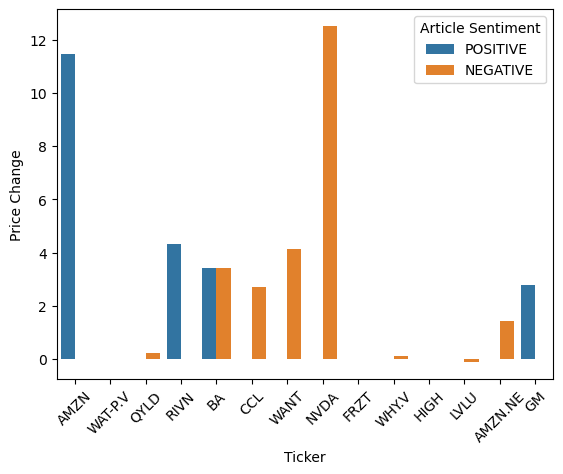

In [8]:
df['Z-score'] = (df['Price Change'] - df['Price Change'].mean()) / df['Price Change'].std()
df = df[(df['Z-score'] > -3) & (df['Z-score'] < 3)]
df = df.drop(columns=['Z-score'])
plt.xticks(rotation=45)

sns.barplot(x=df["Ticker"], y=df["Price Change"], hue=df["Article Sentiment"])